In [1]:
import os, sys
import numpy as np
import pandas as pd
import datetime
from functools import partial
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
sys.path.append(os.path.abspath(os.path.join('./BayesFlow')))
from bayesflow.forward_inference import GenerativeModel, Prior, Simulator
from bayesflow.networks import InvertibleNetwork, InvariantNetwork
from bayesflow.amortized_inference import AmortizedPosterior
from bayesflow.trainers import Trainer
import bayesflow.diagnostics as diag

/home/l/projects/Morpheus/Tutorial/infectionSpread/BayesFlow/bayesflow/trainers.py:16: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
import time
import glob
import subprocess

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)
tf.config.experimental.set_memory_growth(gpus[1], True)
#gpu_options = tf.GPUOptions(allow_growth=True)
#sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
#keras.backend.tensorflow_backend.set_session(sess)

2022-08-22 14:57:00.052197: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-22 14:57:00.052506: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-22 14:57:00.136286: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-22 14:57:00.136606: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-22 14:57:00.136882: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
RNG = np.random.default_rng(2022)

In [7]:
def model_prior():
    b_cf = RNG.uniform(low=0.01,high=1)
    b_c2c = RNG.uniform(low=0.01,high=1)
    c_V = RNG.uniform(low=0.01,high=1)
    p_i = RNG.uniform(low=0.01,high=1)
    res = np.array([b_cf, b_c2c, c_V, p_i])
    return res

In [8]:
prior = Prior(prior_fun=model_prior, param_names=[r'b_cf',r'b_c2c',r'c_V',r'p_i'])

In [9]:
prior_means, prior_stds = prior.estimate_means_and_stds()

In [10]:
def run_morpheus(params, T0=10, t=100):
    b_cf, b_c2c, c_V, p_i = params
    
    #I0 = np.ceil(I0)
    #T = np.clip(T0-I0, 0, T0)
    
    #!MODEL_DIR='model'
    #!MODEL="$(ls  ${DIR}/${MODEL_DIR}/*.xml)"
    model_dir='model'
    model=glob.glob(os.path.join(os.getcwd(),'model','*.xml'))[0]
    print(model)

    OUT=os.path.join(os.getcwd(), 'output', 'bcf-' + str(b_cf) + '_' + 'bc2c-' + str(b_c2c) + '_' + 'cV-' + str(c_V) + '_' + 'pi-' +  str(p_i))
    print(OUT)
    !mkdir "$OUT"
    !morpheus -f "$model" -o "$OUT" -b_cf="$b_cf" -b_c2c="$b_c2c" -c_V="$c_V" -p_i="$p_i"
    
    final_plot = os.path.join(OUT,'plot-1_' + str(t).zfill(5) + '.png')
    while not os.path.exists(final_plot):
        time.sleep(1)
    
    population_file = os.path.join(OUT,'logger_3.csv')
    pop = np.genfromtxt(population_file, delimiter='\t', names=True)
    pop = np.array([list(i) for i in zip(*pop)])
    return np.expand_dims(pop[2,:], axis=1)

In [11]:
config = {
    'T' : 10,
    't' : 100
}

In [12]:
simulator = Simulator(simulator_fun=partial(run_morpheus, T0=config['T'], t=config['t']))

In [13]:
model = GenerativeModel(prior, simulator, name='morpheus')

/home/l/projects/Morpheus/Tutorial/infectionSpread/model/Sweep_25_07.xml
/home/l/projects/Morpheus/Tutorial/infectionSpread/output/bcf-0.11508424227575569_bc2c-0.15691539364305926_cV-0.900586277640427_pi-0.5570802440707895
mkdir: das Verzeichnis »/home/l/projects/Morpheus/Tutorial/infectionSpread/output/bcf-0.11508424227575569_bc2c-0.15691539364305926_cV-0.900586277640427_pi-0.5570802440707895“ kann nicht angelegt werden: Die Datei existiert bereits
Setting output directory /home/l/projects/Morpheus/Tutorial/infectionSpread/output/bcf-0.11508424227575569_bc2c-0.15691539364305926_cV-0.900586277640427_pi-0.5570802440707895
Initializing from file /home/l/projects/Morpheus/Tutorial/infectionSpread/model/Sweep_25_07.xml
Registering Symbol time of linktype TimeLink in Scope root
Time/RandomSeed not specified, using arbitray seed (based on time).
Random seed of master thread = 1661173023
Random seed of thread 14 = 3164557
Random seed of thread 12 = 3898197
Random seed of thread 2 = 6914586
Ra

INFO:root:Performing 2 pilot runs with the morpheus model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 4)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 101, 1)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


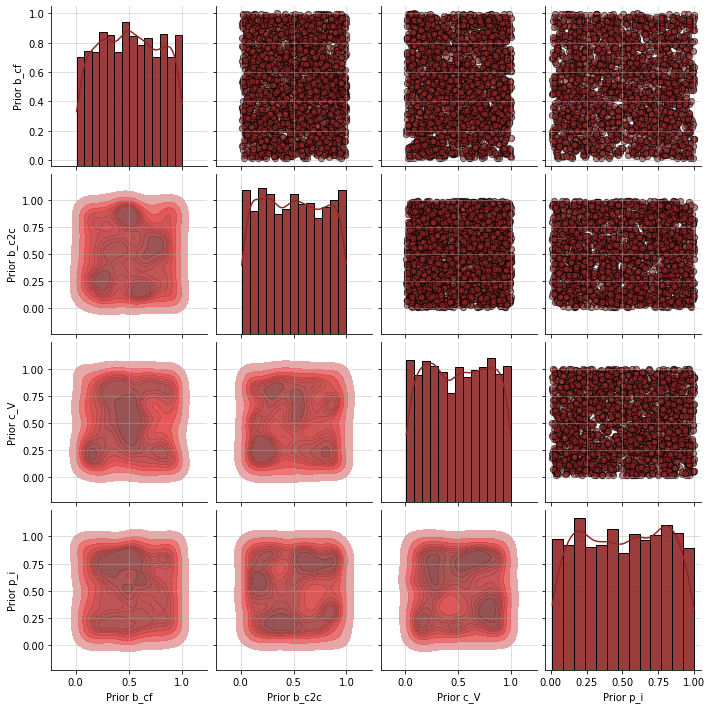

In [14]:
f = prior.plot_prior2d()

In [15]:
class ConvLSTM(tf.keras.Model):
    def __init__(self, n_summary):
        super(ConvLSTM, self).__init__()
        
        self.conv =  tf.keras.Sequential([
            tf.keras.layers.Conv1D(n_summary, kernel_size=3, strides=1, 
                                   padding='causal', activation='relu', kernel_initializer='glorot_uniform'),
            tf.keras.layers.Conv1D(n_summary*2, kernel_size=2, strides=1, 
                                   padding='causal', activation='relu', kernel_initializer='glorot_uniform'),
            tf.keras.layers.Conv1D(n_summary*3, kernel_size=1, strides=1, 
                                   padding='causal', activation='relu', kernel_initializer='glorot_uniform')
        ])
        self.lstm = tf.keras.layers.LSTM(n_summary)

    def call(self, x, **args):
        """x is a 3D tensor of shape (batch_size, n_time_steps, n_time_series)"""

        out = self.conv(x)
        out = self.lstm(out)
        return out

In [16]:
summary_net = ConvLSTM(n_summary=5)

2022-08-22 14:57:16.043304: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-22 14:57:16.219850: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-22 14:57:16.220132: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-22 14:57:16.220377: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [17]:
inference_net = InvertibleNetwork({
    'n_params': 4, 
    'n_coupling_layers': 3, 
})

In [18]:
amortizer = AmortizedPosterior(inference_net, summary_net, name='amortizer')

In [19]:
def configure_input(forward_dict):
    """ Function to configure the simulated quantities (i.e., simulator outputs)
    into a neural network-friendly (BayesFlow) format.
    """
    
    # Prepare placeholder dict
    out_dict = {}
    
    # Convert data to logscale 
    logdata = np.log1p(forward_dict['sim_data']).astype(np.float32)
    
    # Extract prior draws and z-standardize with previously computed means
    params = forward_dict['prior_draws'].astype(np.float32)
    params = (params - prior_means) / prior_stds
    
    # Remove a batch if it contains nan, inf or -inf
    idx_keep = np.all(np.isfinite(logdata), axis=(1, 2))
    if not np.all(idx_keep):
        print('Invalid value encountered...removing from batch')
    
    # Add to keys
    out_dict['summary_conditions'] = logdata[idx_keep]
    out_dict['parameters'] = params[idx_keep]
    
    return out_dict

In [20]:
# change var_obs
trainer = Trainer(amortizer=amortizer, 
                  generative_model=model, 
                  configurator=configure_input)

INFO:root:Performing a consistency check with provided components...


/home/l/projects/Morpheus/Tutorial/infectionSpread/model/Sweep_25_07.xml
/home/l/projects/Morpheus/Tutorial/infectionSpread/output/bcf-0.2653308375535468_bc2c-0.828759331064651_cV-0.5086726795005022_pi-0.5494142133204155
mkdir: das Verzeichnis »/home/l/projects/Morpheus/Tutorial/infectionSpread/output/bcf-0.2653308375535468_bc2c-0.828759331064651_cV-0.5086726795005022_pi-0.5494142133204155“ kann nicht angelegt werden: Die Datei existiert bereits
Setting output directory /home/l/projects/Morpheus/Tutorial/infectionSpread/output/bcf-0.2653308375535468_bc2c-0.828759331064651_cV-0.5086726795005022_pi-0.5494142133204155
Initializing from file /home/l/projects/Morpheus/Tutorial/infectionSpread/model/Sweep_25_07.xml
Registering Symbol time of linktype TimeLink in Scope root
Time/RandomSeed not specified, using arbitray seed (based on time).
Random seed of master thread = 1661173039
Random seed of thread 1 = 8401729
Random seed of thread 8 = 2852095
Random seed of thread 11 = 1109350
Random se

2022-08-22 14:57:23.954585: E tensorflow/stream_executor/cuda/cuda_dnn.cc:389] Could not create cudnn handle: CUDNN_STATUS_INTERNAL_ERROR
2022-08-22 14:57:23.955362: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at conv_ops.cc:1120 : UNIMPLEMENTED: DNN library is not found.


ConfigurationError: Could not carry out computations of generative_model ->configurator -> amortizer -> loss! Error trace:
 Exception encountered when calling layer "conv1d" (type Conv1D).

DNN library is not found. [Op:Conv2D]

Call arguments received by layer "conv1d" (type Conv1D):
  • inputs=tf.Tensor(shape=(2, 101, 1), dtype=float32)

In [21]:
amortizer.summary()

Model: "amortizer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 invertible_network (Inverti  multiple                 57672     
 bleNetwork)                                                     
                                                                 
 conv_lstm (ConvLSTM)        multiple                  715       
                                                                 
Total params: 58,387
Trainable params: 58,363
Non-trainable params: 24
_________________________________________________________________


In [22]:
#%%time
#_ = model(32)

In [ ]:
%%time
h = trainer.train_online(epochs=2, iterations_per_epoch=2, batch_size=5)

Training epoch 1:   0%|          | 0/10 [00:00<?, ?it/s]

/home/l/projects/Morpheus/Tutorial/infectionSpread/model/Sweep_25_07.xml
/home/l/projects/Morpheus/Tutorial/infectionSpread/output/bcf-0.5997762956986353_bc2c-0.5761422208559233_cV-0.4992321936195816_pi-0.3343243009959866
mkdir: das Verzeichnis »/home/l/projects/Morpheus/Tutorial/infectionSpread/output/bcf-0.5997762956986353_bc2c-0.5761422208559233_cV-0.4992321936195816_pi-0.3343243009959866“ kann nicht angelegt werden: Die Datei existiert bereits
Setting output directory /home/l/projects/Morpheus/Tutorial/infectionSpread/output/bcf-0.5997762956986353_bc2c-0.5761422208559233_cV-0.4992321936195816_pi-0.3343243009959866
Initializing from file /home/l/projects/Morpheus/Tutorial/infectionSpread/model/Sweep_25_07.xml
Registering Symbol time of linktype TimeLink in Scope root
Time/RandomSeed not specified, using arbitray seed (based on time).
Random seed of master thread = 1661168992
Random seed of thread 8 = 3590783
Random seed of thread 6 = 9967142
Random seed of thread 9 = 6175675
Random 

Training epoch 2:   0%|          | 0/10 [00:00<?, ?it/s]

/home/l/projects/Morpheus/Tutorial/infectionSpread/model/Sweep_25_07.xml
/home/l/projects/Morpheus/Tutorial/infectionSpread/output/bcf-0.5973216816874041_bc2c-0.23228412084752567_cV-0.46508176680604296_pi-0.8150335505087726
mkdir: das Verzeichnis »/home/l/projects/Morpheus/Tutorial/infectionSpread/output/bcf-0.5973216816874041_bc2c-0.23228412084752567_cV-0.46508176680604296_pi-0.8150335505087726“ kann nicht angelegt werden: Die Datei existiert bereits
Setting output directory /home/l/projects/Morpheus/Tutorial/infectionSpread/output/bcf-0.5973216816874041_bc2c-0.23228412084752567_cV-0.46508176680604296_pi-0.8150335505087726
Initializing from file /home/l/projects/Morpheus/Tutorial/infectionSpread/model/Sweep_25_07.xml
Registering Symbol time of linktype TimeLink in Scope root
Time/RandomSeed not specified, using arbitray seed (based on time).
Random seed of master thread = 1661169074
Random seed of thread 5 = 2630572
Random seed of thread 1 = 3527715
Random seed of thread 13 = 6601094


In [24]:
h

,Default.Loss
0,1.453266


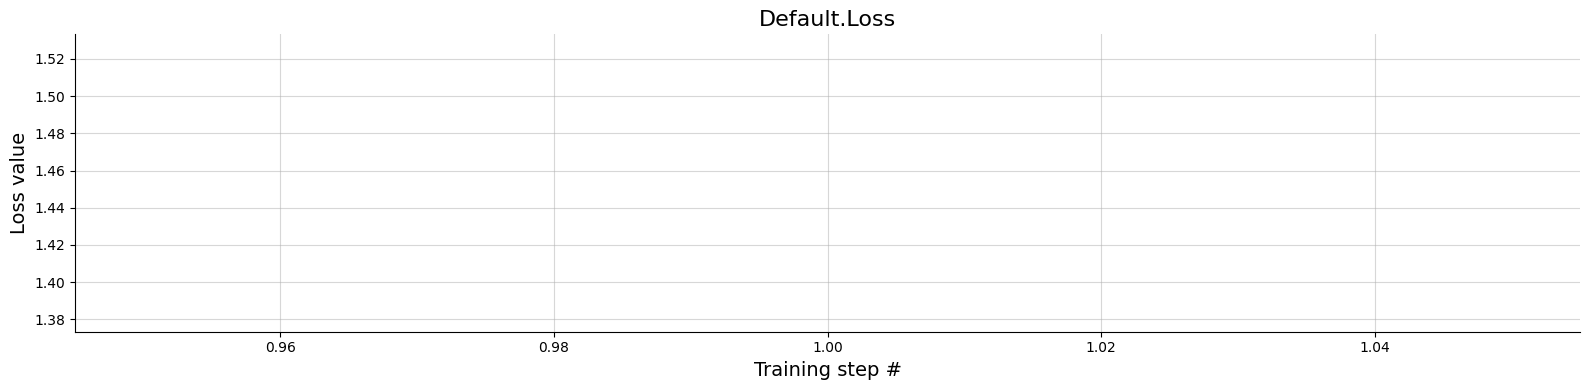

In [25]:
f = diag.plot_losses(h)

In [27]:
f = trainer.diagnose_latent2d()

982.51s - Error inserting pydevd breaks.
Traceback (most recent call last):
  File "/home/lea/projects/INN/morpheus/tutorial/infectionSpread/venv/lib/python3.8/site-packages/debugpy/_vendored/pydevd/_pydevd_frame_eval/pydevd_modify_bytecode.py", line 328, in insert_pydevd_breaks
    for new_instruction in get_instructions_to_add(
  File "/home/lea/projects/INN/morpheus/tutorial/infectionSpread/venv/lib/python3.8/site-packages/debugpy/_vendored/pydevd/_pydevd_frame_eval/pydevd_modify_bytecode.py", line 102, in get_instructions_to_add
    Instr("LOAD_CONST", _pydev_stop_at_break, lineno=stop_at_line - 1),
  File "/home/lea/projects/INN/morpheus/tutorial/infectionSpread/venv/lib/python3.8/site-packages/debugpy/_vendored/pydevd/_pydevd_frame_eval/vendored/bytecode/instr.py", line 171, in __init__
    self._set(name, arg, lineno)
  File "/home/lea/projects/INN/morpheus/tutorial/infectionSpread/venv/lib/python3.8/site-packages/debugpy/_vendored/pydevd/_pydevd_frame_eval/vendored/bytecode/ins

AttributeError: Exception encountered when calling layer "amortizer" (type AmortizedPosterior).

'NoneType' object has no attribute 'get'

Call arguments received by layer "amortizer" (type AmortizedPosterior):
  • input_dict=None
  • return_summary=False
  • kwargs={'training': 'None'}

In [28]:
f = trainer.diagnose_sbc_histograms()

TypeError: 'NoneType' object is not subscriptable

In [15]:
b_cf = 1
b_c2c = 1
c_V = 1
p_i = 1
I0 = 1
params = np.array([b_cf, b_c2c, c_V, p_i, I0])

In [17]:
pop = run_morpheus(params, 10, 100)

/home/lea/projects/INN/morpheus/tutorial/Sweep_25_07/model/Sweep_25_07.xml
/home/lea/projects/INN/morpheus/tutorial/Sweep_25_07/output/bcf-1_bc2c-1_cV-1_pi-1
mkdir: das Verzeichnis »/home/lea/projects/INN/morpheus/tutorial/Sweep_25_07/output/bcf-1_bc2c-1_cV-1_pi-1“ kann nicht angelegt werden: Die Datei existiert bereits
Setting output directory /home/lea/projects/INN/morpheus/tutorial/Sweep_25_07/output/bcf-1_bc2c-1_cV-1_pi-1
Initializing from file /home/lea/projects/INN/morpheus/tutorial/Sweep_25_07/model/Sweep_25_07.xml
Registering Symbol time of linktype TimeLink in Scope root
Time/RandomSeed not specified, using arbitray seed (based on time).
Random seed of master thread = 1659355370
Random seed of thread 7 = 9507902
Random seed of thread 6 = 6909739
Random seed of thread 3 = 267710
Random seed of thread 1 = 1639870
Random seed of thread 2 = 8365403
Random seed of thread 4 = 751819
Random seed of thread 5 = 2297337
Registering Symbol space of linktype LocationLink in Scope root
Reg

In [46]:
pop = np.genfromtxt('/home/lea/projects/INN/morpheus/tutorial/Sweep_25_07/output/sweep_bcf-0.1_bc2c-0.1_cV-0.1_pi-0.1_1/logger_3.csv', delimiter='\t', names=True)
pop = np.array([list(i) for i in zip(*pop)])
pop[:,2]

In [30]:
OUT=os.path.join(os.getcwd(), 'output', 'bcf-' + str(b_cf) + '_' + 'bc2c-' + str(b_c2c) + '_' + 'cV-' + str(c_V) + '_' + 'pi-' +  str(p_i))
population_file = os.path.join(OUT,'logger_3.csv')
pop = np.genfromtxt(population_file, delimiter='\t', names=True)
pop = np.array([list(i) for i in zip(*pop)])
pop = np.expand_dims(pop[2,:], axis=1)

In [19]:
popul = np.genfromtxt('/home/lea/projects/INN/morpheus/tutorial/Sweep_25_07/output/sweep_bcf-0.1_bc2c-0.1_cV-0.1_pi-0.1_1/logger_3.csv', delimiter='\t', names=True)

In [31]:
pop

array([[ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 2.],
       [ 4.],
       [ 6.],
       [ 7.],
       [ 9.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
      

In [26]:
popul[2,:]

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  2.,  2.,  2.,  2.,  3.,  3.,  3.,  4.,  4.,  4.,
        4.,  5.,  8.,  8.,  8.,  8.,  8.,  8.,  9.,  9.,  9., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10.])

In [13]:
model_dir='model'
models=glob.glob(os.path.join(os.getcwd(),'model','*.xml'))
model=models[0]
!echo "$model"
#!morpheus -f '/home/lea/projects/INN/morpheus/tutorial/Sweep_25_07/model/Sweep_25_07.xml' -o '/home/lea/projects/INN/morpheus/tutorial/Sweep_25_07/output/bcf-1_bc2c-1_cV-1_pi-1'

/home/lea/projects/INN/morpheus/tutorial/Sweep_25_07/model/Sweep_25_07.xml
